# PROBLEM 1

In [1]:
from PIL import Image
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage import filters


### Original Image

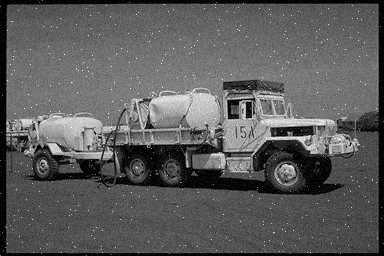

In [2]:
img = Image.open("NoisyImg.bmp")
img

In [3]:
arr_img = np.array(img)
im_med = ndimage.median_filter(arr_img, 3)

### MedianFilter

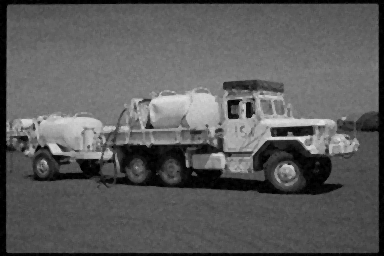

In [4]:
Image.fromarray(im_med).save("Median.bmp")
Image.fromarray(im_med)

In [7]:
noise_std = 0.45*arr_img.std()
noise_var = noise_std**2
noise_var

414.44820025818177

In [8]:
def adaptive_wiener_filter(img,size):
    noisy_var = (0.45*arr_img.std())**2
    imsize = img.shape
    padded = np.pad(img,((size//2,size//2),(size//2,size//2)),'constant')
    result = np.zeros(imsize)
    a = 10
    epsilon_squared = 6.25 * noise_var
    for i in range(imsize[0]):
        for j in range(imsize[1]):
            local_patch = padded[(i+size//2)-size//2:(i+size//2)+size//2+1,(j+size//2)-size//2:(j+size//2)+size//2+1]
            weight_patch = 1/(1+a*np.maximum(epsilon_squared, np.square(local_patch-padded[(i+size//2),(j+size//2)])))
            normalized_weight_patch = weight_patch/np.sum(weight_patch)
            local_mean = np.sum(normalized_weight_patch*local_patch)
            local_var = np.sum(normalized_weight_patch*np.square(local_patch-local_mean))
            result[i,j] = (((padded[(i+size//2),(j+size//2)]-local_mean)*local_var)/(local_var+noise_var))+local_mean
    np.clip(result,0,255,out=result)    
    return result

In [9]:
x = adaptive_wiener_filter(arr_img, 5)

### AdaptiveWeiner Filter

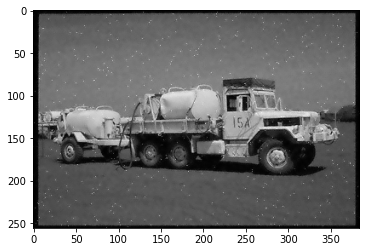

In [10]:
plt.imshow(x, cmap='gray')

In [11]:
def AdaptiveMedianFilter(img, sMax):
    width, height = img.size
    newimg = img.copy()
    filterSize = 3
    borderSize = sMax // 2
    imgMax = img.getpixel((0,0))
    mid = (filterSize*filterSize)//2
    for i in range(width):
        for j in range(height):
            if(imgMax < img.getpixel((i,j))):
                imgMax = img.getpixel((i,j))

    for i in range(borderSize,width-borderSize):
        for j in range(borderSize,height-borderSize):
            members = [imgMax] * (sMax*sMax)
            filterSize = 3
            zxy = img.getpixel((i,j))
            result = zxy
            while(filterSize<=sMax):
                borderS = filterSize // 2
                for k in range(filterSize):
                    for t in range(filterSize):
                        members[k*filterSize+t] = img.getpixel((i+k-borderS,j+t-borderS))
                        #print(members[k*filterSize+t])
                members.sort()
                med  = (filterSize*filterSize)//2
                zmin = members[0]
                zmax = members[(filterSize-1)*(filterSize+1)]
                zmed = members[med]
                if(zmed<zmax and zmed > zmin):
                    if(zxy>zmin and zxy<zmax):
                        result = zxy
                    else: 
                        result = zmed
                    break
                else:
                    filterSize += 2

            newimg.putpixel((i,j),(result))
            
    return newimg


In [12]:
AdaptiveMedianFilter(img, 5).save("AdaptiveMedian.bmp")

### AdaptiveMedian filter

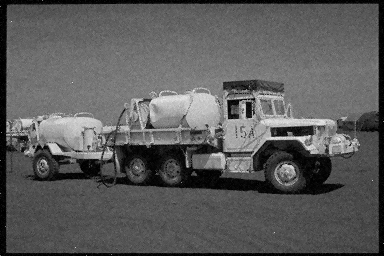

In [13]:
AdaptiveMedianFilter(img, 5)

### AdaptiveMedian + Median Filter

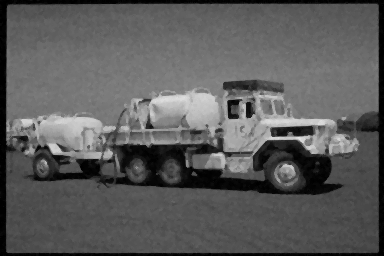

In [14]:
# AdaptiveMedian + Median filter

AdaptiveMedianFilter(Image.open("Median.bmp"), 5)

### Median + AdaptiveWiener Filter

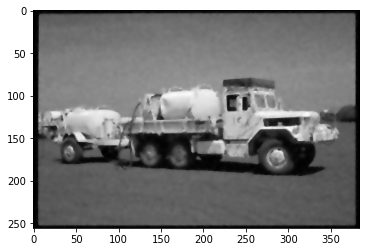

In [15]:
# AdaptiveWiener + Median Filter

plt.imshow(adaptive_wiener_filter(np.array(Image.open("Median.bmp")),5), cmap="gray")

### AdaptiveMedian + AdaptiveWiener Filter

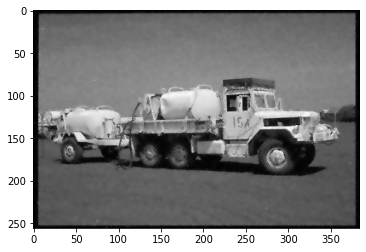

In [16]:
#AdaptiveMedian + AdaptiveWiener Filter
plt.imshow(adaptive_wiener_filter(np.array(Image.open("AdaptiveMedian.bmp")),5), cmap="gray")

### From the images it is clear that AdaptiveMedian + AdaptiveWiener Filter gives the best output when compared to the methods individually or in any other combination.

# PROBLEM 2


### Convolution function

In [18]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib
 
def convolution(image, kernel, average=False, verbose=False):
    if len(image.shape) == 3:
        print("Found 3 Channels : ".format(image.shape))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        print("Converted to Gray Channel. Size : {}".format(image.shape))
 
    image_row, image_col = image.shape
    kernel_row, kernel_col = kernel.shape
 
    output = np.zeros(image.shape)
 
    pad_height = int((kernel_row - 1) / 2)
    pad_width = int((kernel_col - 1) / 2)
 
    padded_image = np.zeros((image_row + (2 * pad_height), image_col + (2 * pad_width)))
 
    padded_image[pad_height:padded_image.shape[0] - pad_height, pad_width:padded_image.shape[1] - pad_width] = image
 
  
 
    for row in range(image_row):
        for col in range(image_col):
            output[row, col] = np.sum(kernel * padded_image[row:row + kernel_row, col:col + kernel_col])
            if average:
                output[row, col] /= kernel.shape[0] * kernel.shape[1]
 
 
    return output

### Implementing the Disk Blur Kernel to later use in the formula

In [19]:
# -*- coding: utf-8 -*-
import numpy as np
from PIL import Image
from scipy.signal import convolve2d
from skimage.draw import circle

defocusKernelDims = [3,5,7,9]



def DiskKernel(dim):
    kernelwidth = dim
    kernel = np.zeros((kernelwidth, kernelwidth), dtype=np.float32)
    circleCenterCoord = dim // 2
    circleRadius = circleCenterCoord +1
    
    rr, cc = circle(circleCenterCoord, circleCenterCoord, circleRadius)
    kernel[rr,cc]=1
    
    if(dim == 3 or dim == 5):
        kernel = Adjust(kernel, dim)
        
    normalizationFactor = np.count_nonzero(kernel)
    kernel = kernel / normalizationFactor
    return kernel

def Adjust(kernel, kernelwidth):
    kernel[0,0] = 0
    kernel[0,kernelwidth-1]=0
    kernel[kernelwidth-1,0]=0
    kernel[kernelwidth-1, kernelwidth-1] =0 
    return kernel

### Using iterative deconvolution and showing outputs for different iterations. The images displayed are in this order: Original image, image after 10 iterations, image after 50 iterations, image after 100 iterations, image after 500 iterations. Beta value is assumed to be 1.9, It is clear from the images that, as the no. of iterations increase, image gets sharper and the amount of ringing increases.

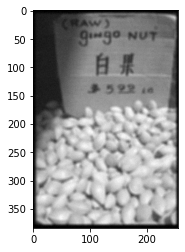

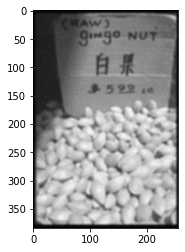

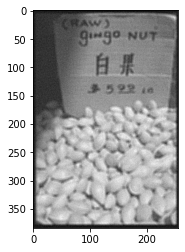

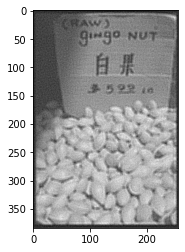

In [ ]:
import numpy as np
import cv2
from numpy import pi, exp, sqrt
from scipy.ndimage.filters import generic_filter as gf
#s, k = 1, 2 
#probs = [exp(-z*z/(2*s*s))/sqrt(2*pi*s*s) for z in range(-k,k+1)] 
#kernel = np.outer(probs, probs)
i=0
beta = 1.9
img = cv2.imread("NoisyBlur.bmp", 0)
f=img
b=DiskKernel(7)
def T(f, beta, kernel):
    
    a=convolution(f,b,average=True,verbose=True)
    return f + beta * (img - a)

def forten():
    f=img
    i=0
    while(i<10):
        f = T(f, beta,b)
        i += 1
    plt.imshow(f, cmap='gray')
    plt.show()

def forfifty():
    f=img
    i=0
    while(i<50):
        f = T(f, beta,b)
        i += 1
    plt.imshow(f, cmap='gray')
    plt.show() 
    
def forhundred():
    f=img
    i=0
    while(i<100):
        f = T(f, beta,b)
        i += 1
    plt.imshow(f, cmap='gray')
    plt.show() 
    

    


  
plt.imshow(img, cmap='gray')
plt.show()
forten()
forfifty()
forhundred()
forfivehundred()


#convolved = convolve2d(imgarray, kernel, mode='same', fillvalue=255.0).astype("uint8")
    #img = Image.fromarray(convolved)

